In [1]:

import pandas as pd
import numpy as np
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import datetime

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.formula.api  import ols
import statsmodels.api as sm


In [3]:

#rawdata = pd.read_csv (r'/Users/cairo/Google Drive/wechat data/016.csv', encoding='utf-8')
topicdata = pd.read_csv(r'C:/Users/Junhao/Google Drive/wechat data/TopicOutcomeAll20Topic.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

#dd = topicdata.head(30)
#dd.to_csv("./tgggsample.csv", sep=',',index=False)

#group the data by its account name
DF_list= list()
for i in topicdata.account.unique():
   dff = topicdata[topicdata["account"].isin([i])]
   dff["std"] = dff.filter(like='topic', axis=1).astype(float).std(axis = 1)
   DF_list.append(dff)
   
#reformat the articles' public time
qq4 = []
for j in DF_list:
    qq3 = []
    for i in j["publicTime"]:
        qq = datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
        qq2 = [qq.year, qq.month, qq.day]
        qq3.append(qq2)
    qq4.append(qq3)

#group the data by its account name with the reformatted public time
DF_list2 = []
for index, item in enumerate(DF_list):
    df2 = pd.DataFrame(qq4[index]) 
    df2a = df2.rename(columns={0: "year", 1: "month", 2:"day"})
    df2a.index = item.index
    df4 = pd.concat([item, df2a], axis=1)
    DF_list2.append(df4)

DF_list2[0]

<ipython-input-3-bfdbd81e2336>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["std"] = dff.filter(like='topic', axis=1).astype(float).std(axis = 1)


,name,account,author,type,title,summary,likeCount,clicksCount,url,publicTime,...,topic14,topic15,topic16,topic17,topic18,topic19,std,year,month,day
0,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,住宾馆时，怎么知道房间有没有针孔摄像头？,近日，有网友爆料：在入住的宾馆里换拖鞋时，在正对着床的沙发上居然发现了一个针孔摄像头！不仔细...,175,27784,http://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2MQ...,2015-01-26 12:55:11,...,46.502632,0.05,0.05,0.05,0.05,0.05,13.824436,2015,1,26
2,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,▶太恶心了，吃火锅前一定要注意，速看！,速看~,113,20763,http://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2MQ...,2015-01-26 12:55:11,...,10.045543,0.05,0.05,0.05,0.05,0.05,2.235071,2015,1,26
4,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,太有用了！看到第二个我就收了!,一. 放个苹果，土豆不发芽二. 用保鲜膜包住根部，可延长香蕉的保存时间三 切水果大全。。。1...,161,17728,http://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2MQ...,2015-01-27 21:38:15,...,0.05,0.05,0.05,0.05,0.05,0.05,17.162513,2015,1,27
7,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,南京人童年殿堂级零食 你吃过多少？,今年，辣条莫名其妙就火了，其实我们大蓝鲸人童年额零食有着丰富的选择，不过不少都是父母严令禁吃...,50,11997,http://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2MQ...,2015-01-12 08:13:15,...,0.05,10.749091,0.05,0.05,362.8626,2.0349836,80.781316,2015,1,12
9,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,和一个南京人讨论n、l 的后果。。。别怪我没提醒你！,摇摆！,36,9355,http://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2MQ...,2015-01-27 21:38:15,...,20.210014,0.05,0.05,0.05,0.05,0.05,6.427769,2015,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231779,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,珍珠泉改造完工！即将美成仙境，这个秋天去刚刚好！,找个好天气，去珍珠泉玩耍吧~,14,2571,https://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2M...,2019-09-12 20:30:15,...,0.05,0.05,0.05,0.05,19.716532,0.05,66.270948,2019,9,12
4231850,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,南京新增5条机场线！以后可以直飞这几个地方！,哇！,5,2782,https://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2M...,2019-09-23 23:15:02,...,0.05,0.05,0.05,0.05,0.05,0.05,25.586159,2019,9,23
4231946,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,极度心塞！看了眼明年的中秋节日期，居然...,心塞,0,2026,https://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2M...,2019-09-17 20:05:05,...,37.78758,0.05,16.114706,0.05,0.05,0.05,12.230301,2019,9,17
4231973,南京吃喝玩乐,happyinnanjing,南京吃喝玩乐,民生,「老头老太」家常小店，带你重温童年味道！,一家一家打卡吧！,3,2238,https://mp.weixin.qq.com/s?__biz=MjM5NTkwNTI2M...,2019-09-14 20:15:30,...,7.065537,0.05,0.05,0.05,497.19577,0.05,111.050801,2019,9,14


In [7]:
#take the mean values of topic weights, clicksCount, and likeCount in each time window (i.e., each month). For instance, it can give me the average weight of topic1 and average likeCount of Dec 2015.

monthstd_list=[]
for j in DF_list2:
    j.topic1 = j.topic1.astype(float)
    j.topic2 = j.topic2.astype(float)
    j.topic3 = j.topic3.astype(float)
    j.topic4 = j.topic4.astype(float)
    j.topic5 = j.topic5.astype(float)
    j.topic9 = j.topic9.astype(float)
    j.topic14 = j.topic14.astype(float)
    j.topic15 = j.topic15.astype(float)
    j.clicksCount = j.clicksCount.astype(float)
    j.likeCount = j.likeCount.astype(float)
    jj = j.groupby(['year','month']).agg(topic1=('topic1', 'mean'),topic2=('topic2', 'mean'), topic3=('topic3', 'mean')
                                         , topic4=('topic4', 'mean'), topic5=('topic5', 'mean'), topic9=('topic9', 'mean')
                                         , topic14=('topic14', 'mean'), topic15=('topic15', 'mean'), 
                                         clicksCount=('clicksCount', 'mean'), likeCount=('likeCount', 'mean')).reset_index(drop=False)
    monthstd_list.append(jj)
    
flat_monthstd = pd.concat(monthstd_list) #Data was grouped in list by each account. This part flattern the list



In [9]:
#plot the correlation of topic weightings to likecount over time. The plot below shows that topic1 has really positive correlation with likes during the first 8 months and around month 40.  
corrall = flat_monthstd.groupby(flat_monthstd.index)[['topic1','likeCount']].corr().unstack().iloc[:,1]
corrall2 = corrall.to_frame()
corrall2.columns = ['corr'] 
corrall2.plot(y='corr')


<AxesSubplot:>

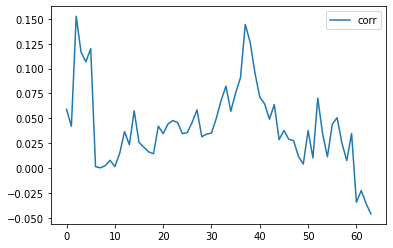